## Calculate FRC from select data source

This notebook shows how to programmatically take an FRC of a specific data source.


In [1]:
from __future__ import print_function
from PYME.recipes import modules
from PYME.LMVis import pipeline
from PYMEcs.misc.utils import pyme_logging_filter

pyme_logging_filter() # supress a few minor warnings

data = pipeline.Pipeline("16_1_series_BB_microtubules_STORM.h5r")

In [2]:
# load our saved recipe
data.recipe.update_from_yaml('16_1_series_BB.yaml')
print("Current data source: %s" % data.selectedDataSourceKey) # what is the currently selected data source
print("Available data sources: %s" % ', '.join(data.dataSources.keys())) # look at all the data sources we could select

data.selectDataSource('drift_corrected')
print("Number of events in data source is %d" % data.x.size)

Current data source: filtered_localizations
Available data sources: FitResults, Localizations, colour_mapped, filtered_localizations, drift_corrected
Number of events in data source is 332575


In [3]:
from PYME.recipes import localisations
tb = localisations.TimeBlocks(input='drift_corrected',output='tbdc',
                                 block_size=100)
data.recipe.add_module(tb)
dm = localisations.DensityMapping(
        inputLocalizations='tbdc',
        jitterVariable="error_x",
        outputImage="FRCdc",
        pixelSize=5.0,
        renderingModule='Gaussian',
        colours=['block0','block1'])
data.recipe.add_module(dm)
data.recipe.execute()

Created colour filter with chans: ['block0', 'block1']


In [4]:
image = data.dataSources['FRCdc']
image.data_xyztc.shape

(3193, 3568, 1, 1, 2)

In [5]:
from PYMEcs.experimental import FRC

freqs,frc1,smoothed,fhb,f7,halfbit = FRC.frc_from_image(image,[0,1])
print('res-1/7     = %3.1f nm' % (1.0/f7[0]))

res-1/7     = 82.6 nm


<IPython.core.display.Javascript object>


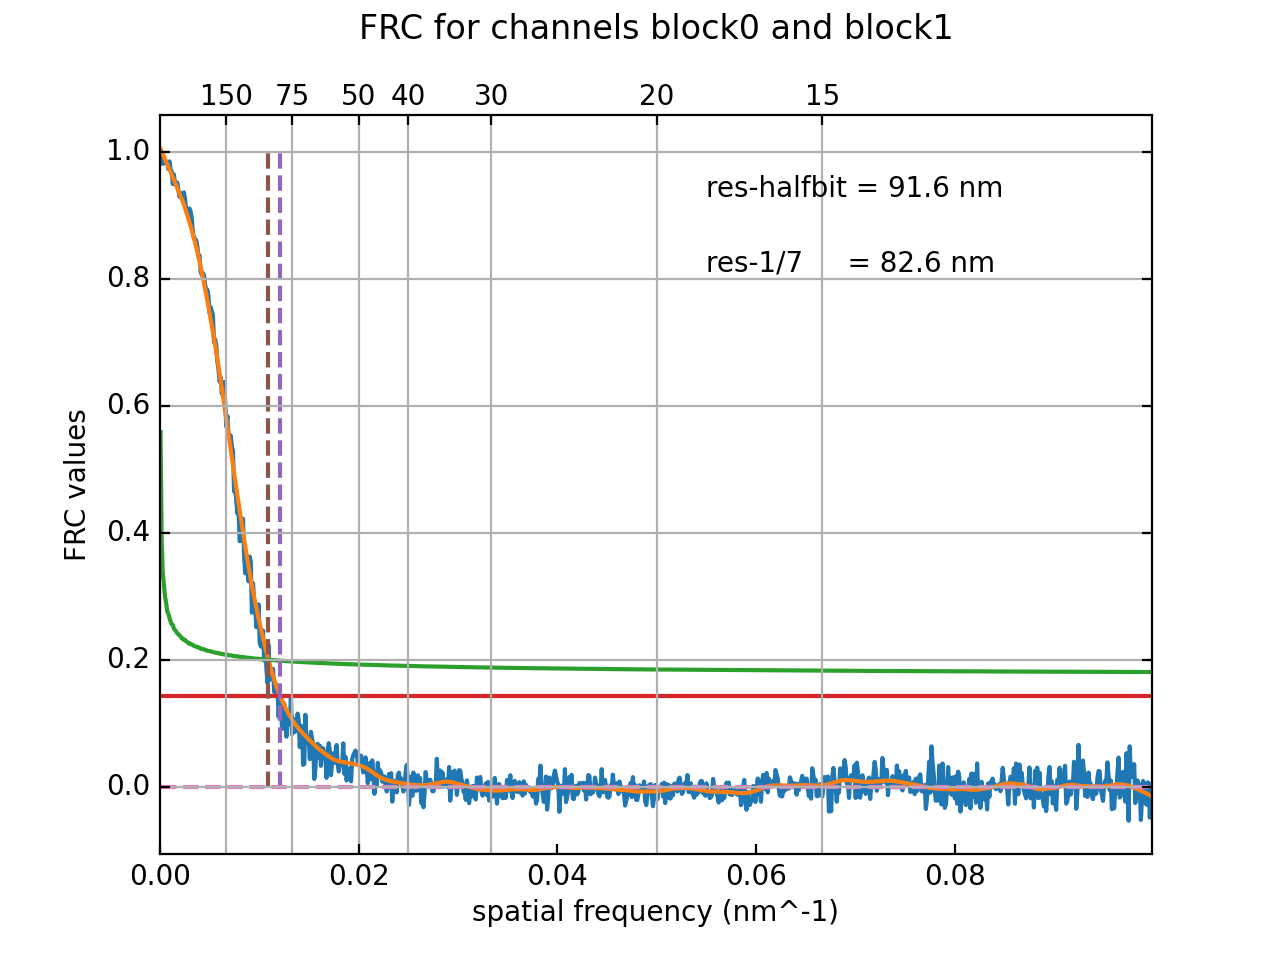

In [6]:
%matplotlib notebook
FRC.frc_plot(freqs,frc1,smoothed,fhb,f7,halfbit,showHalfbitThreshold=True)

In [7]:
def rgbwrap(r,g=None,b=None,vmax=None,vmin=None):
    if vmax is None:
        vmax = r.max()
    if vmin is None:
        vmin = r.min()
    rgbim = np.zeros(list(r.shape[0:2])+[3])
    rgbim[:,:,0] = (r-vmin)/(vmin+vmax)
    if not (g is None):
        rgbim[:,:,1] = (g-vmin)/(vmin+vmax)
    if not (b is None):
        rgbim[:,:,2] = (b-vmin)/(vmin+vmax)
    return rgbim

<IPython.core.display.Javascript object>


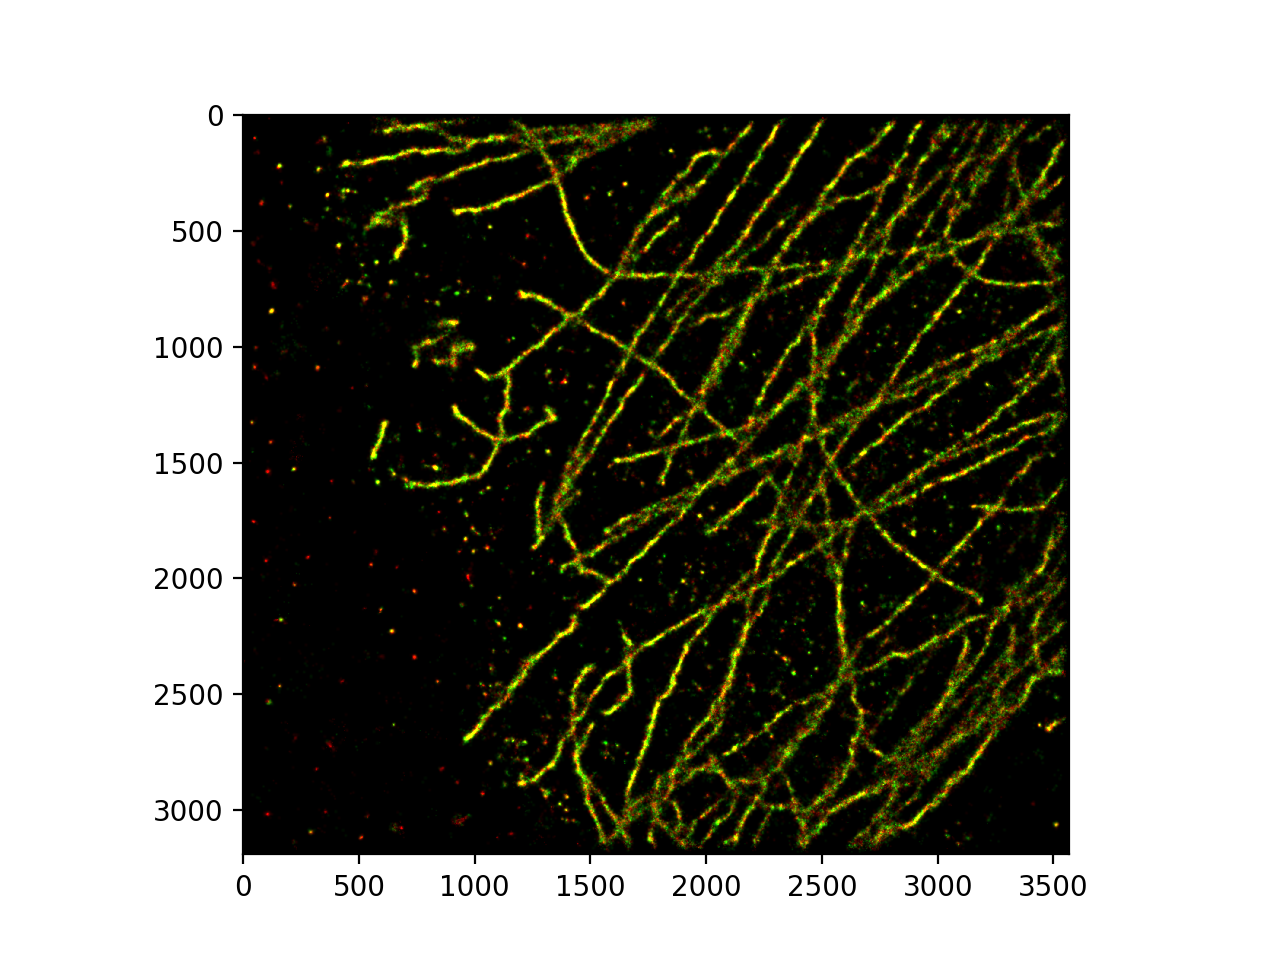

In [8]:
rgbim = rgbwrap(image.data_xytc[:,:,0,0].squeeze(),image.data_xytc[:,:,0,1].squeeze(),vmax=0.75)
plt.figure()
plt.imshow(rgbim)

<IPython.core.display.Javascript object>


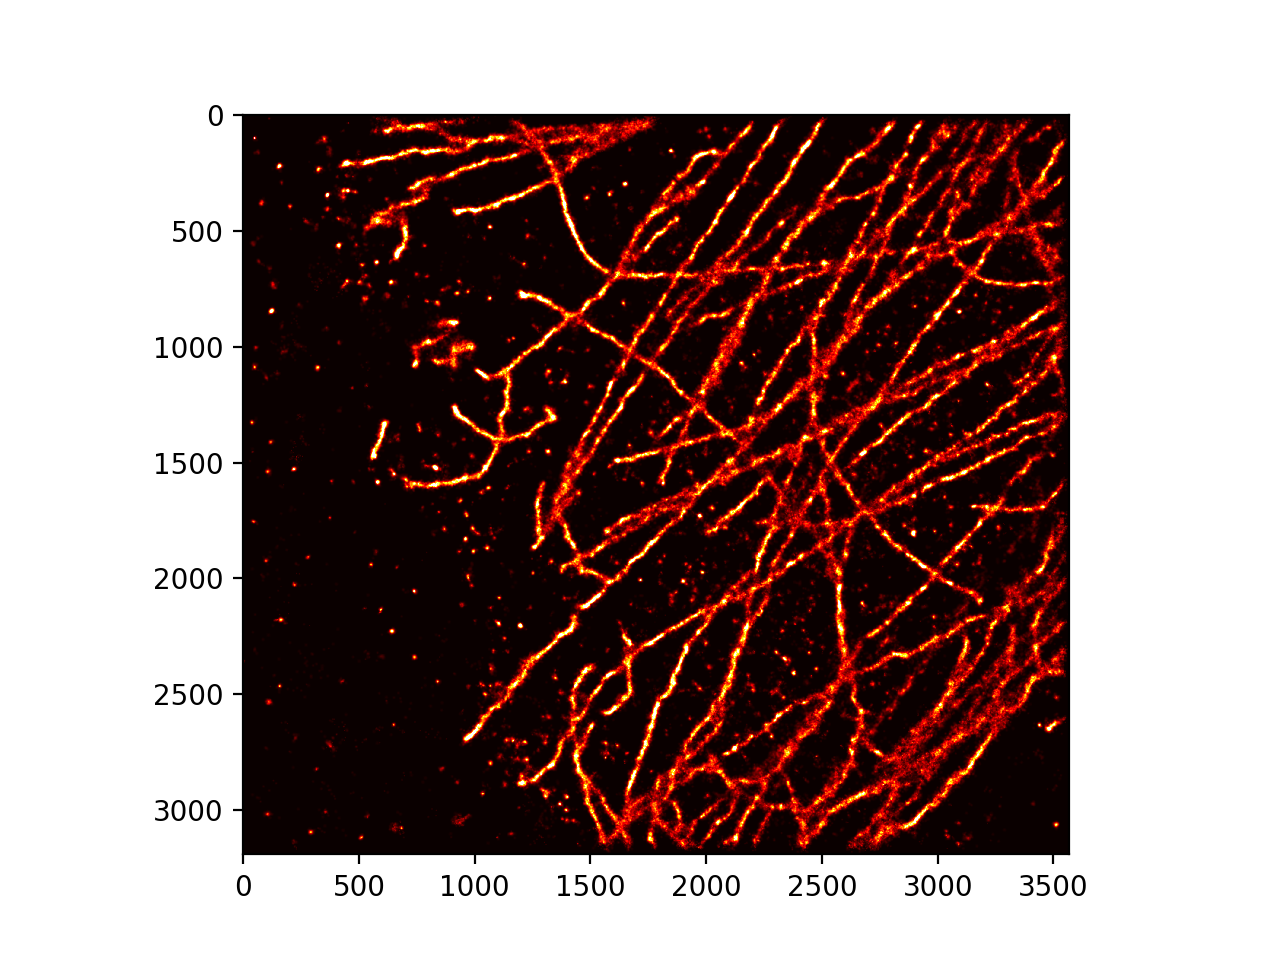

In [9]:
flatim = image.data_xytc[:,:,0,0].squeeze()+image.data_xytc[:,:,0,1].squeeze()
plt.figure()
plt.imshow(flatim,cmap='hot',vmax=1.5)